In [5]:
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import seaborn as sns

from packaging import version

# import the new functionality
from pymc.model.transform.conditioning import do

RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'



In [6]:
rng

Generator(PCG64) at 0x17E3426C0

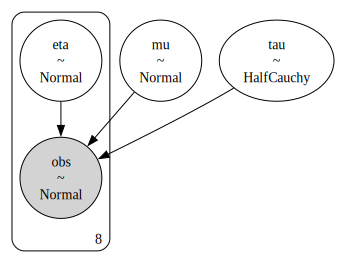

In [2]:
J = 8
y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
sigma = np.array([15, 10, 16, 11, 9, 11, 10, 18])

with pm.Model() as schools:
    eta = pm.Normal("eta", 0, 1, shape=J)
    mu = pm.Normal("mu", 0, sigma=1e6)
    tau = pm.HalfCauchy("tau", 25)
    theta = mu + tau * eta
    obs = pm.Normal("obs", theta, sigma=sigma, observed=y)

pm.model_to_graphviz(schools)

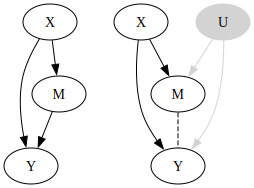

In [8]:
g = gr.Digraph()
# Wrong data generating process
g.node(name="x2", label="X")
g.node(name="y2", label="Y")
g.node(name="m2", label="M")
g.edge(tail_name="x2", head_name="y2")
g.edge(tail_name="x2", head_name="m2")
g.edge(tail_name="m2", head_name="y2")
# Actual causal DAG
g.node(name="x", label="X")
g.node(name="y", label="Y")
g.node(name="m", label="M")
g.node(name="u", label="U", color="lightgrey", style="filled")
g.edge(tail_name="x", head_name="y")
g.edge(tail_name="x", head_name="m")
g.edge(tail_name="m", head_name="y", style="dashed", dir="none")
g.edge(tail_name="u", head_name="m", color="lightgrey")
g.edge(tail_name="u", head_name="y", color="lightgrey")
# Render
g

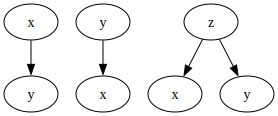

In [3]:
g = gr.Digraph()

# DAG 1
g.node(name="x1", label="x")
g.node(name="y1", label="y")
g.edge(tail_name="x1", head_name="y1")

# DAG 2
g.node(name="y2", label="y")
g.node(name="x2", label="x")
g.edge(tail_name="y2", head_name="x2")

# DAG 3
g.node(name="z", label="z")
g.node(name="x", label="x")
g.node(name="y", label="y")
g.edge(tail_name="z", head_name="x")
g.edge(tail_name="z", head_name="y")

g

Sampling: [temp, x]


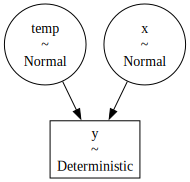

In [10]:
# number of samples to generate
N = 1_000_000
# DAG1
x = rng.normal(loc=0, scale=1, size=N)
y = x + 1 + np.sqrt(3) * rng.normal(size=N)

with pm.Model() as model1:
    x = pm.Normal("x")
    temp = pm.Normal("temp")
    y = pm.Deterministic("y", x + 1 + np.sqrt(3) * temp)
    idata1 = pm.sample_prior_predictive(samples=N, random_seed=rng)

ds1 = az.extract(idata1.prior, var_names=["x", "y"])

pm.model_to_graphviz(model1)

Sampling: [temp, y]


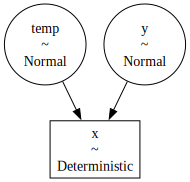

In [11]:
# DAG2
y = 1 + 2 * rng.normal(size=N)
x = (y - 1) / 4 + np.sqrt(3) * rng.normal(size=N) / 2

with pm.Model() as model2:
    y = pm.Normal("y", mu=1, sigma=2)
    temp = pm.Normal("temp")
    x = pm.Deterministic("x", (y - 1) / 4 + np.sqrt(3) * temp / 2)
    idata2 = pm.sample_prior_predictive(samples=N, random_seed=rng)

ds2 = az.extract(idata2.prior, var_names=["x", "y"])

pm.model_to_graphviz(model2)

Sampling: [temp, z]


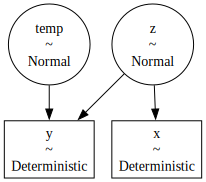

In [12]:
# DAG3
z = rng.normal(size=N)
y = z + 1 + np.sqrt(3) * rng.normal(size=N)
x = z

with pm.Model() as model3:
    z = pm.Normal("z")
    temp = pm.Normal("temp")
    y = pm.Deterministic("y", z + 1 + np.sqrt(3) * temp)
    x = pm.Deterministic("x", z)
    idata3 = pm.sample_prior_predictive(samples=N)

ds3 = az.extract(idata3.prior, var_names=["x", "y"])

pm.model_to_graphviz(model3)

# Distributions

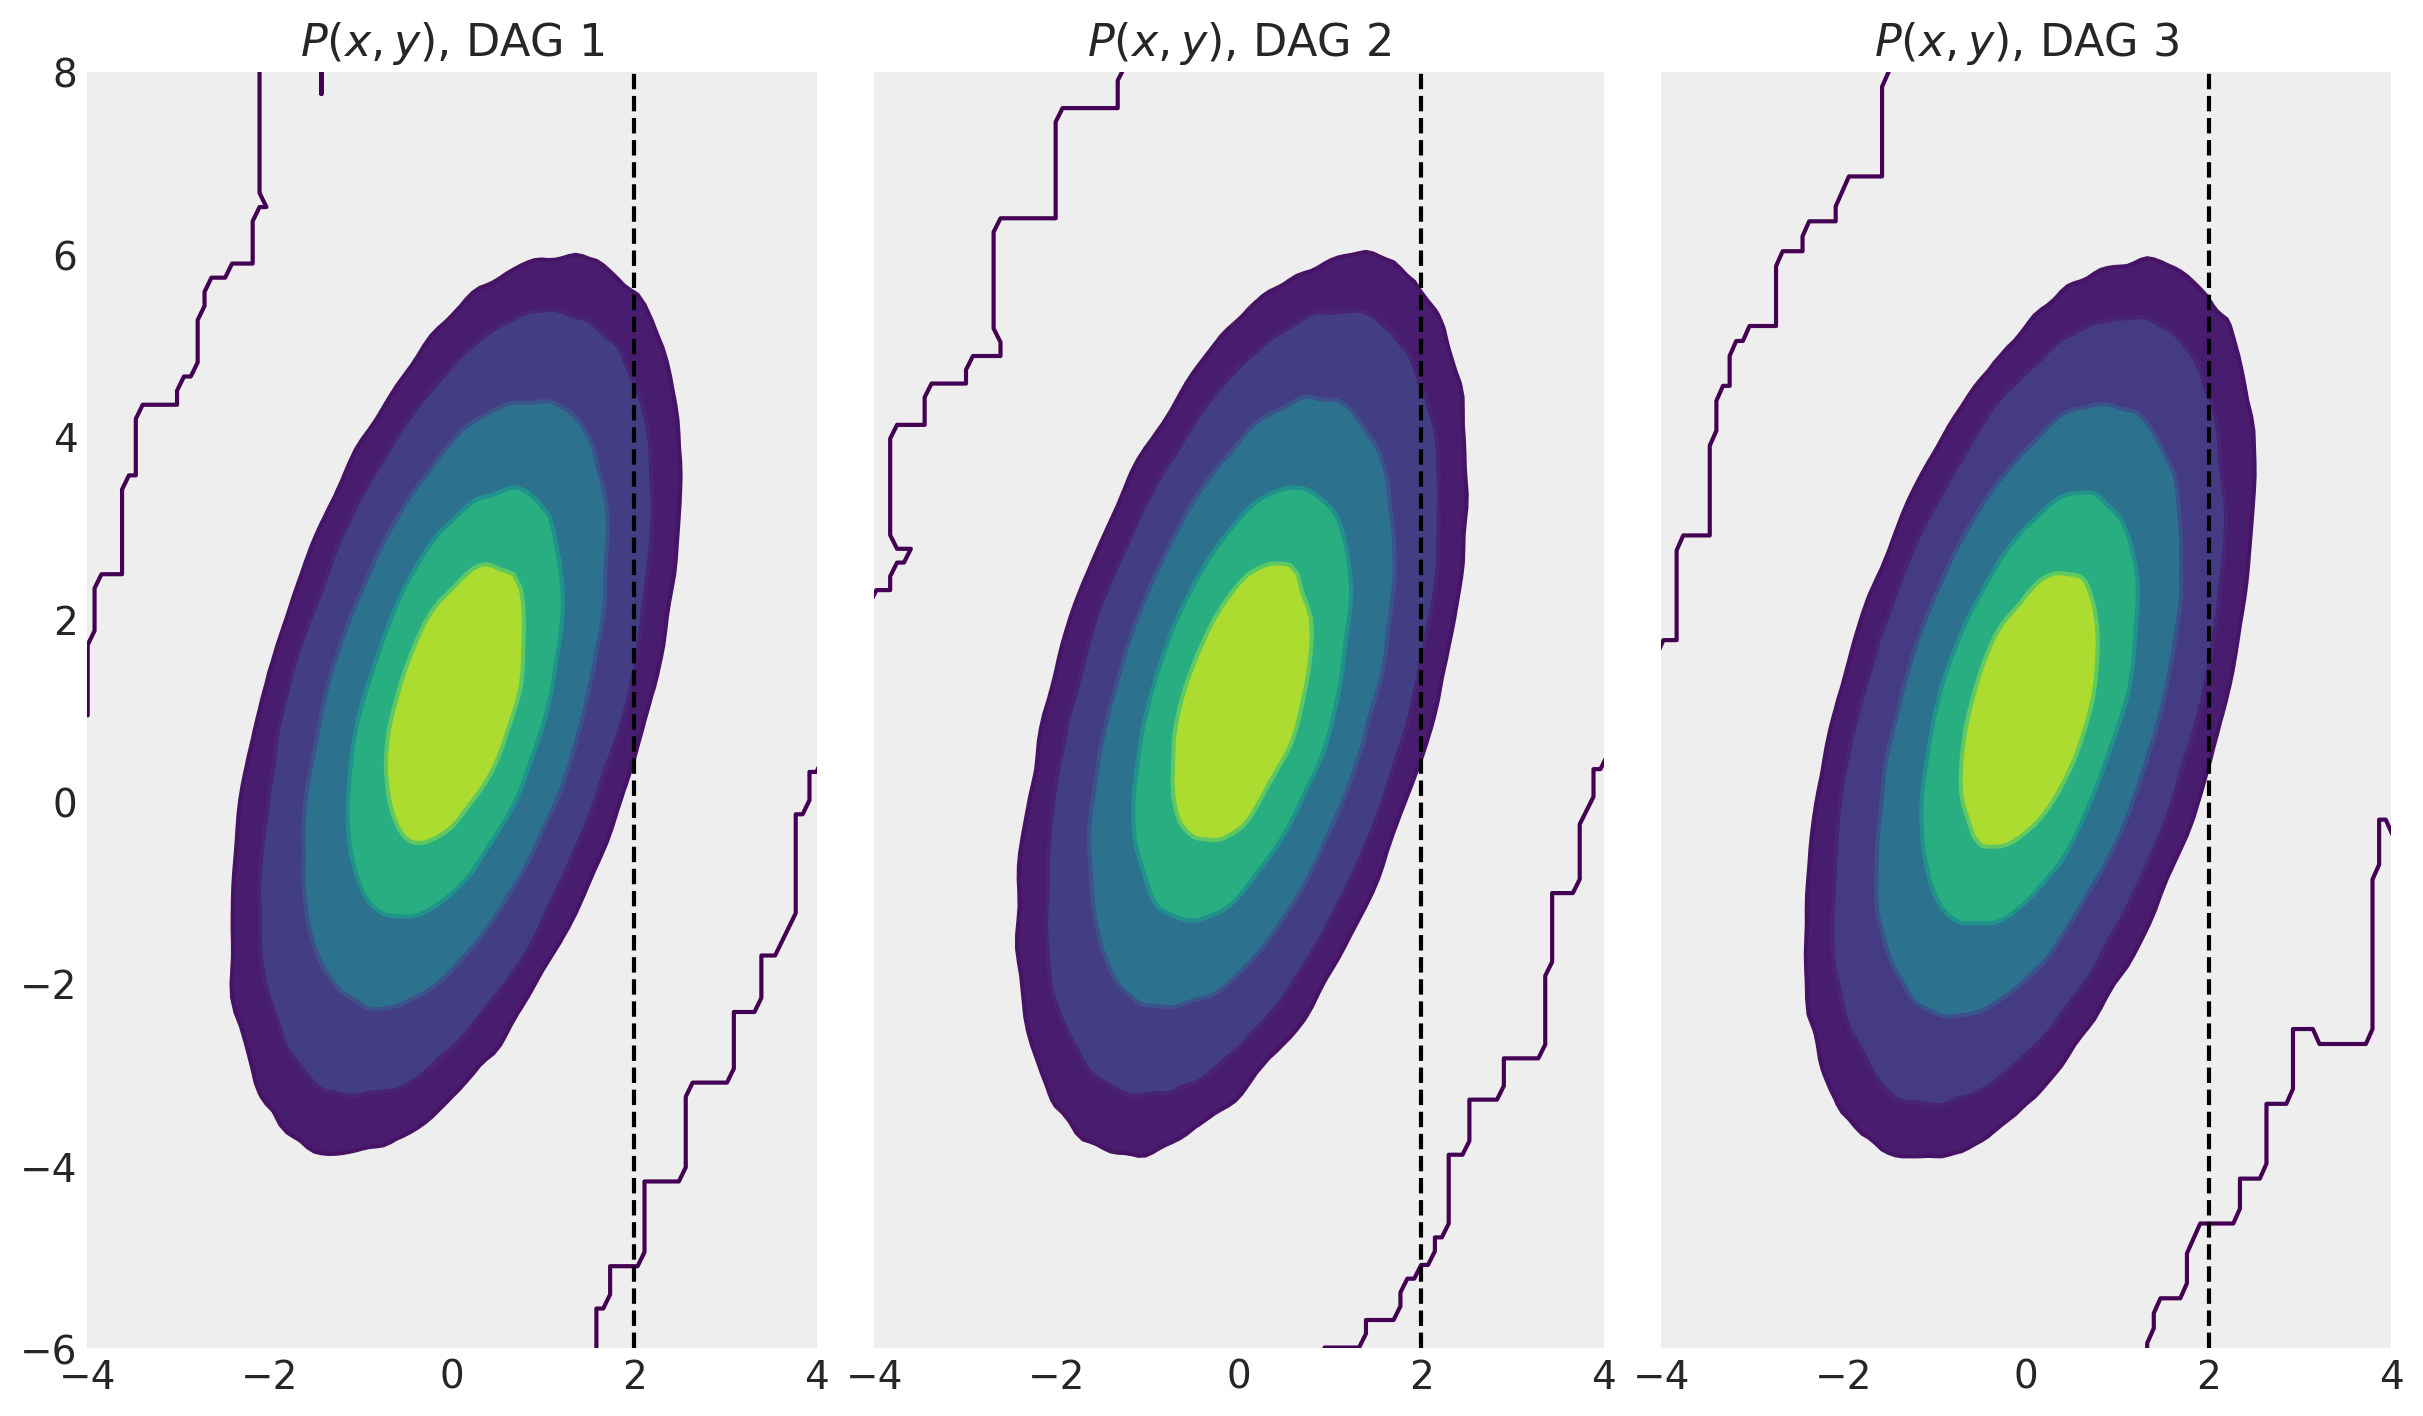

In [13]:
# Joint Distribution
fig, ax = plt.subplots(1, 3, figsize=(12, 8), sharex=True, sharey=True)

for i, ds in enumerate([ds1, ds2, ds3]):
    az.plot_kde(
        ds["x"],
        ds["y"],
        hdi_probs=[0.25, 0.5, 0.75, 0.9, 0.95],
        contour_kwargs={"colors": None},
        contourf_kwargs={"alpha": 0.5},
        ax=ax[i],
    )
    ax[i].set(
        title=f"$P(x, y)$, DAG {i+1}",
        xlim=[-4, 4],
        xticks=np.arange(-4, 4 + 1, step=2),
        ylim=[-6, 8],
        yticks=np.arange(-6, 8 + 1, step=2),
        aspect="equal",
    )
    ax[i].axvline(x=2, ls="--", c="k")

In [20]:
# Conditional Distribution
# Extract samples from P(y|x≈2)
conditional1 = ds1.query(sample="1.99 < x < 2.01")["y"]
conditional2 = ds2.query(sample="1.99 < x < 2.01")["y"]
conditional3 = ds3.query(sample="1.99 < x < 2.01")["y"]


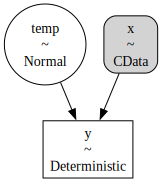

In [14]:
# Interventional Distribution
model1_do = do(model1, {"x": 2})
pm.model_to_graphviz(model1_do)

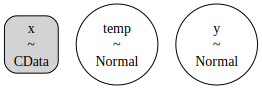

In [17]:
model2_do = do(model2, {"x": 2})
pm.model_to_graphviz(model2_do)

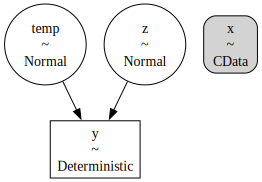

In [15]:
model3_do = do(model3, {"x": 2})
pm.model_to_graphviz(model3_do)

In [18]:
with model1_do:
    idata1_do = pm.sample_prior_predictive(samples=N, random_seed=rng)

with model2_do:
    idata2_do = pm.sample_prior_predictive(samples=N, random_seed=rng)

with model3_do:
    idata3_do = pm.sample_prior_predictive(samples=N, random_seed=rng)

Sampling: [temp]
Sampling: [temp, y]
Sampling: [temp, z]


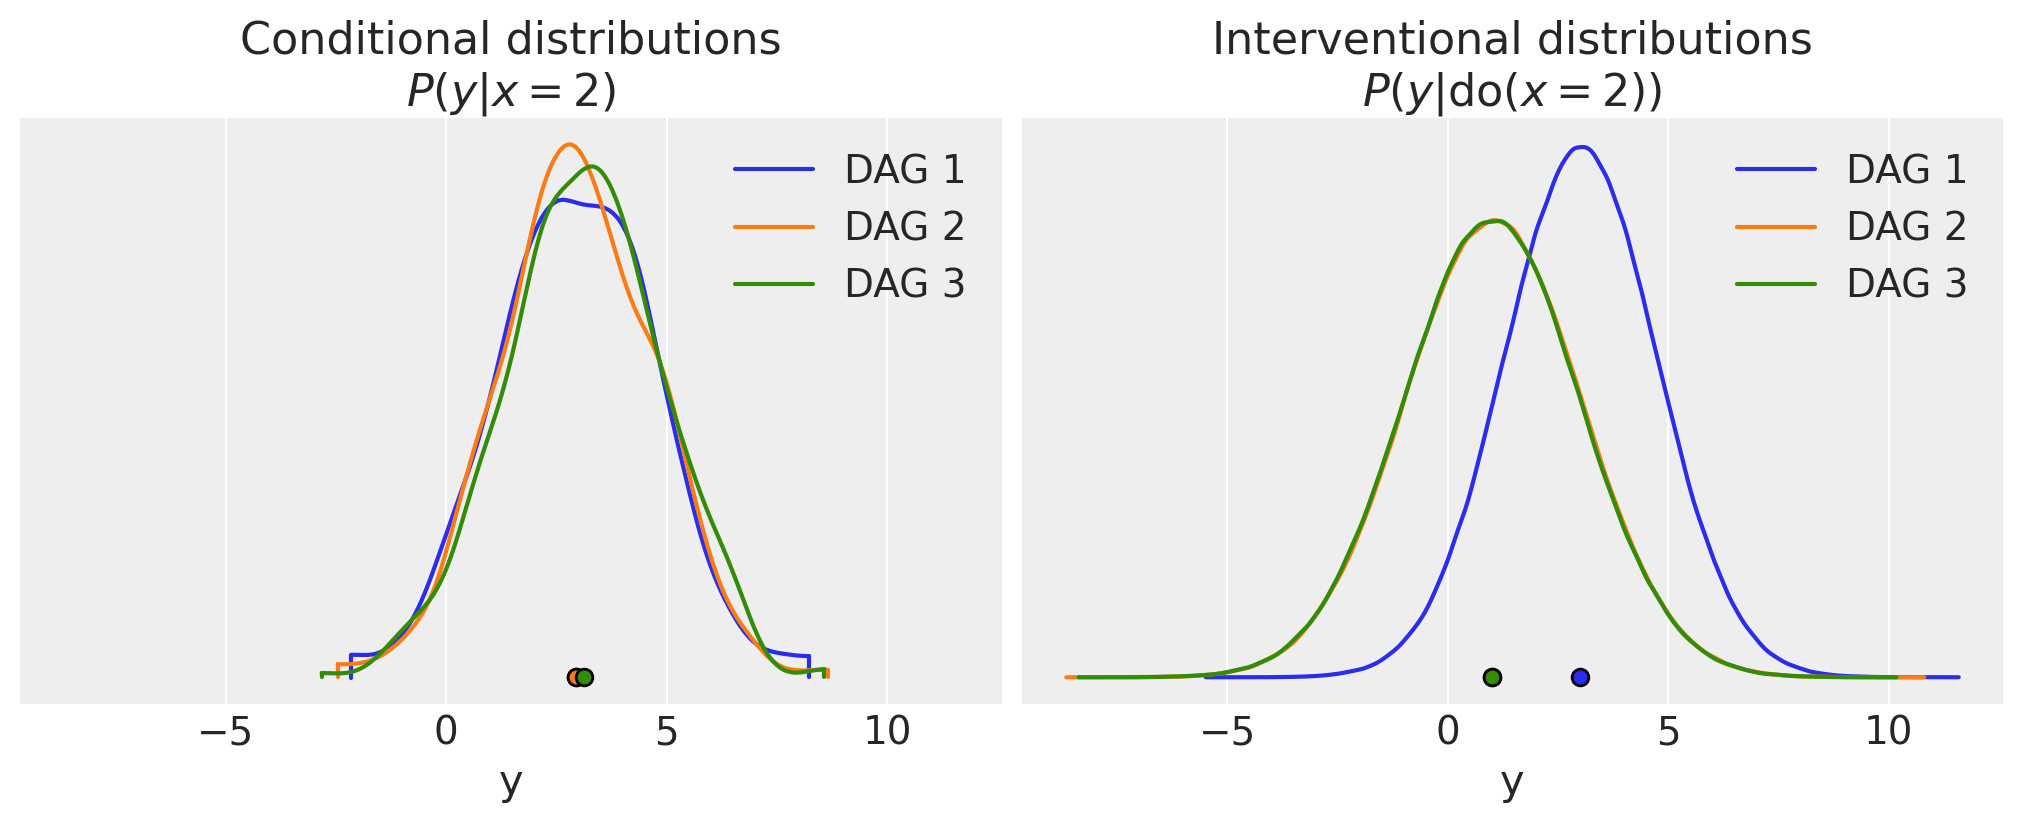

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

az.plot_density(
    [conditional1, conditional2, conditional3],
    data_labels=["DAG 1", "DAG 2", "DAG 3"],
    combine_dims={"sample"},
    ax=ax[0],
    hdi_prob=1.0,
)
ax[0].set(xlabel="y", title="Conditional distributions\n$P(y|x=2)$")

az.plot_density(
    [idata1_do, idata2_do, idata3_do],
    data_labels=["DAG 1", "DAG 2", "DAG 3"],
    group="prior",
    var_names="y",
    ax=ax[1],
    hdi_prob=1.0,
)
ax[1].set(xlabel="y", title="Interventional distributions\n$P(y|\\operatorname{do}(x=2))$");

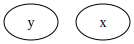

In [22]:
g = gr.Digraph()
g.node(name="y2", label="y")
g.node(name="x2", label="x")
g

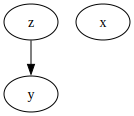

In [23]:
g = gr.Digraph()
g.node(name="z", label="z")
g.node(name="x", label="x")
g.node(name="y", label="y")
g.edge(tail_name="z", head_name="y")
g

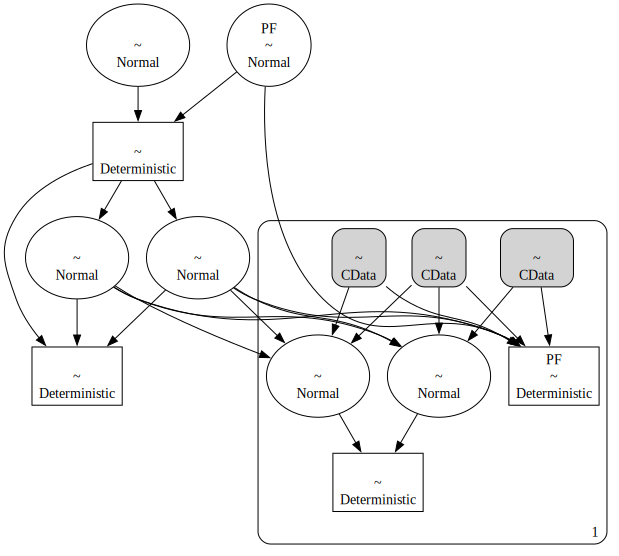